In [1]:
from pyspark.sql import *
from pprint import pprint
import numpy as np

spark = SparkSession.builder.appName("mnist").getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')

Image Display Code

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_image(subset):    
    nrows = 4
    ncols = 5
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in xrange(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(subset[i].toArray().reshape((20,20)), cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

# (1a)

Standardize the data and calculate the covariance matrix

In [3]:
from pyspark.mllib.feature import PCA, StandardScaler
from pyspark.mllib.linalg.distributed import *
from pyspark.mllib.linalg import Vectors

# convert Row into Vector inside the RDD to use StandardScaler
vdf = df.map(lambda x: Vectors.dense([float(c) for c in x['features']]))

# standardize the data
std_df = StandardScaler(True, True).fit(vdf).transform(vdf)

mat = RowMatrix(std_df)
cov_mat = mat.computeCovariance()

Calculate the eigenvectors/values

In [4]:
evals, evecs = np.linalg.eig(cov_mat.toArray())
etuples = [(np.abs(evals[i]), evecs[:,i]) for i in xrange(784)]
etuples = spark.sparkContext.parallelize(etuples).sortByKey(ascending=False)

Selecting Principal Components

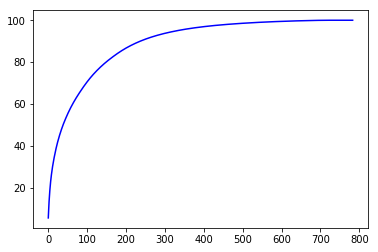

96.9387227793


In [5]:
from operator import add

etotal = etuples.map(lambda x: x[0]).reduce(add)
expl_var = etuples.map(lambda x: 100*(x[0] / etotal))
cum_expl_var = np.cumsum(expl_var.collect())

plt.plot(xrange(784), cum_expl_var, 'b-')
plt.show()
print cum_expl_var[400]

Visual inspection followed by a quick query shows that 96.94% of the variance can be explained by the first 400 principal components. Therefore we can safely drop almost half the principal components.

Projecting the Data

In [6]:
def as_block_matrix(rdd, rowsPerBlock=1024, colsPerBlock=1024):
    return IndexedRowMatrix(
        rdd.zipWithIndex().map(lambda xi: IndexedRow(xi[1], xi[0]))
    ).toBlockMatrix(rowsPerBlock, colsPerBlock)

emat = np.hstack(etuples.map(lambda x: x[1].reshape(784,1)).collect()[:400])
emat = spark.sparkContext.parallelize(emat)
pcomp = as_block_matrix(std_df).multiply(as_block_matrix(emat)).toIndexedRowMatrix()
pcomp = pcomp.toRowMatrix().rows

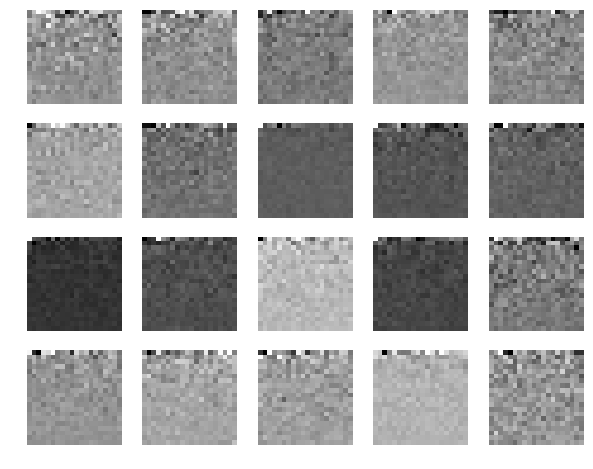

In [13]:
show_image(pcomp.take(20))

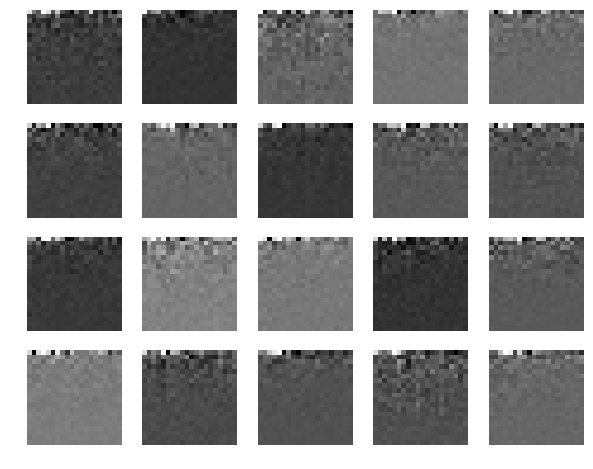

In [17]:
model = PCA(400).fit(vdf)
pc = model.transform(vdf)
show_image(pc.take(20))